# JanataHack: Machine Learning for IoT

You are working with the government to transform your city into a smart city. The vision is to convert it into a digital and intelligent city to improve the efficiency of services for the citizens. One of the problems faced by the government is traffic. You are a data scientist working to manage the traffic of the city better and to provide input on infrastructure planning for the future.

The government wants to implement a robust traffic system for the city by being prepared for traffic peaks. They want to understand the traffic patterns of the four junctions of the city. Traffic patterns on holidays, as well as on various other occasions during the year, differ from normal working days. This is important to take into account for your forecasting. 

Your task

To predict traffic patterns in each of these four junctions for the next 4 months.

The sensors on each of these junctions were collecting data at different times, hence you will see traffic data from different time periods. To add to the complexity, some of the junctions have provided limited or sparse data requiring thoughtfulness when creating future projections. Depending upon the historical data of 20 months, the government is looking to you to deliver accurate traffic projections for the coming four months. Your algorithm will become the foundation of a larger transformation to make your city smart and intelligent.

# Data Dictionary

Variable	Description
ID

Unique ID

DateTime	
Hourly Datetime Variable

Junction
Junction Type

Vehicles

Number of Vehicles (Target)


sample_submission.csv


Column Name	Description
ID

Unique ID

Vehicles

Number of Vehicles (Target)

# Evaluation Metric
The evaluation metric for this competition is Root Mean Squared Error (RMSE)

In [75]:
# import libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler,StandardScaler
from sklearn.svm import LinearSVC
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
import lightgbm as ltb
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import RidgeCV
from mlxtend.regressor import StackingRegressor
from sklearn.metrics import mean_squared_error as mse
import math
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

In [2]:
# read the train and test files and explore the data
train = pd.read_csv("train_aWnotuB.csv")
test  = pd.read_csv("test_BdBKkAj_L87Nc3S.csv")
sub   = pd.read_csv("sample_submission_KVKNmI7.csv")

In [3]:
# explore the training data
train.head()

,DateTime,Junction,Vehicles,ID
0,2015-11-01 00:00:00,1,15,20151101001
1,2015-11-01 01:00:00,1,13,20151101011
2,2015-11-01 02:00:00,1,10,20151101021
3,2015-11-01 03:00:00,1,7,20151101031
4,2015-11-01 04:00:00,1,9,20151101041


In [4]:
train.dtypes

DateTime    object
Junction     int64
Vehicles     int64
ID           int64
dtype: object

In [5]:
train.isnull().sum()

DateTime    0
Junction    0
Vehicles    0
ID          0
dtype: int64

In [6]:
train['DateTime'] = pd.to_datetime(train['DateTime'])

In [7]:
train.DateTime.min(),train.DateTime.max()

(Timestamp('2015-11-01 00:00:00'), Timestamp('2017-06-30 23:00:00'))

In [8]:
train.shape,train.ID.nunique()

((48120, 4), 48120)

In [9]:
train.Junction.unique()

array([1, 2, 3, 4], dtype=int64)

In [10]:
def createtimefeatures(df) :
    
    df['hour']         = df['DateTime'].dt.hour
    df['dayofweek']    = df['DateTime'].dt.dayofweek
    df['quarter']      = df['DateTime'].dt.quarter
    df['month']        = df['DateTime'].dt.month
    df['year']         = df['DateTime'].dt.year
    df['dayofyear']    = df['DateTime'].dt.dayofyear
    df['dayofmonth']   = df['DateTime'].dt.day
    df['weekofyear']   = df['DateTime'].dt.weekofyear
    

In [11]:
createtimefeatures(train)
train.head()

,DateTime,Junction,Vehicles,ID,hour,dayofweek,quarter,month,year,dayofyear,dayofmonth,weekofyear
0,2015-11-01 00:00:00,1,15,20151101001,0,6,4,11,2015,305,1,44
1,2015-11-01 01:00:00,1,13,20151101011,1,6,4,11,2015,305,1,44
2,2015-11-01 02:00:00,1,10,20151101021,2,6,4,11,2015,305,1,44
3,2015-11-01 03:00:00,1,7,20151101031,3,6,4,11,2015,305,1,44
4,2015-11-01 04:00:00,1,9,20151101041,4,6,4,11,2015,305,1,44


In [125]:
total_daily = train.groupby(['dayofyear','hour','Junction'])['Vehicles'].sum()
#total_monthly = train.groupby(['month','dayofyear','Junction'])['Vehicles'].sum()
#total_weekly = train.groupby(['weekofyear','dayofyear','Junction'])['Vehicles'].sum()
total_daily

dayofyear  hour  Junction
1          0     1           40
                 2           15
                 3           13
                 4            3
           1     1           36
                 2           10
                 3           11
                 4            1
           2     1           28
                 2            7
                 3           11
                 4            4
           3     1           22
                 2           11
                 3            8
                 4            4
           4     1           24
                 2           10
                 3            6
                 4            2
           5     1           20
                 2            8
                 3            8
                 4            1
           6     1           21
                 2           11
                 3           10
                 4            1
           7     1           26
                 2            9
              

In [13]:
def totalvehiclesdaily(year,day,junct) :
    return total_daily[year,day,junct]

In [126]:
import progressbar
from time import sleep
bar = progressbar.ProgressBar(maxval=train.shape[0], \
    widgets=[progressbar.Bar('=', '[', ']'), ' ', progressbar.Percentage()])
total_daily_count = []
#total_monthly_count = []
#total_weekly_count = []
k =0
bar.start()
for i in range(train.shape[0]) :
    total_daily_count.append(total_daily[train.iloc[i,9],train.iloc[i,4],train.iloc[i,1]])
    #total_monthly_count.append(total_monthly[train.iloc[i,7],train.iloc[i,9],train.iloc[i,1]])
    #total_weekly_count.append(total_weekly[train.iloc[i,11],train.iloc[i,9],train.iloc[i,1]])
    bar.update(i+1)
    k = k+1
bar.finish()
train['total_daily_count'] = total_daily_count
#train['total_monthly_count'] = total_monthly_count
#train['total_weekly_count'] = total_weekly_count

[========================================================================] 100%


In [12]:
train.head(20)

,DateTime,Junction,Vehicles,ID,hour,dayofweek,quarter,month,year,dayofyear,dayofmonth,weekofyear
0,2015-11-01 00:00:00,1,15,20151101001,0,6,4,11,2015,305,1,44
1,2015-11-01 01:00:00,1,13,20151101011,1,6,4,11,2015,305,1,44
2,2015-11-01 02:00:00,1,10,20151101021,2,6,4,11,2015,305,1,44
3,2015-11-01 03:00:00,1,7,20151101031,3,6,4,11,2015,305,1,44
4,2015-11-01 04:00:00,1,9,20151101041,4,6,4,11,2015,305,1,44
5,2015-11-01 05:00:00,1,6,20151101051,5,6,4,11,2015,305,1,44
6,2015-11-01 06:00:00,1,9,20151101061,6,6,4,11,2015,305,1,44
7,2015-11-01 07:00:00,1,8,20151101071,7,6,4,11,2015,305,1,44
8,2015-11-01 08:00:00,1,11,20151101081,8,6,4,11,2015,305,1,44
9,2015-11-01 09:00:00,1,12,20151101091,9,6,4,11,2015,305,1,44


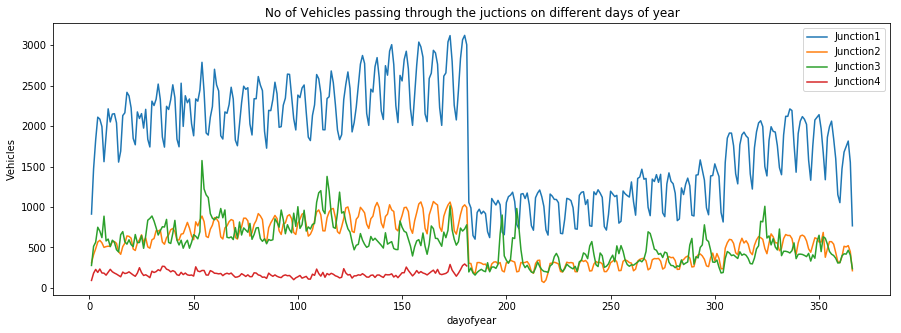

In [28]:
# No of vehicles based on Day of Year
fig = plt.figure(figsize=(15,5))
plt.title("No of Vehicles passing through the juctions on different days of year")
doy_1 = train[train.Junction ==1].groupby(['dayofyear'])['Vehicles'].sum()
doy_2 = train[train.Junction ==2].groupby(['dayofyear'])['Vehicles'].sum()
doy_3 = train[train.Junction ==3].groupby(['dayofyear'])['Vehicles'].sum()
doy_4 = train[train.Junction ==4].groupby(['dayofyear'])['Vehicles'].sum()
sns.lineplot(doy_1.index,doy_1,label='Junction1')
sns.lineplot(doy_2.index,doy_2,label='Junction2')
sns.lineplot(doy_3.index,doy_3,label='Junction3')
sns.lineplot(doy_4.index,doy_4,label='Junction4')

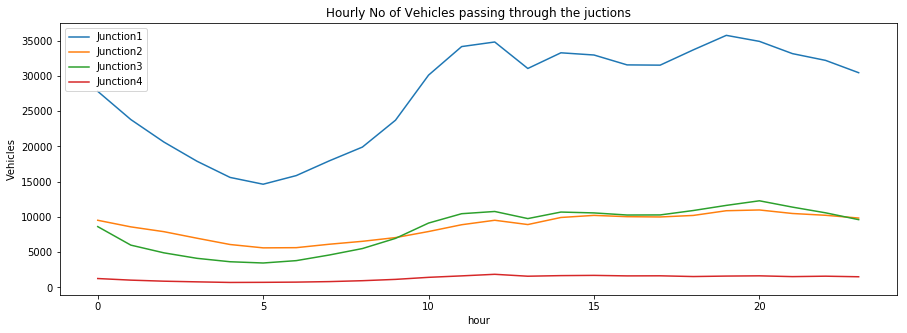

In [29]:
# No of vehicles based on hour of day
fig = plt.figure(figsize=(15,5))
plt.title("Hourly No of Vehicles passing through the juctions")
hourly_1 = train[train.Junction ==1].groupby(['hour'])['Vehicles'].sum()
hourly_2 = train[train.Junction ==2].groupby(['hour'])['Vehicles'].sum()
hourly_3 = train[train.Junction ==3].groupby(['hour'])['Vehicles'].sum()
hourly_4 = train[train.Junction ==4].groupby(['hour'])['Vehicles'].sum()
sns.lineplot(hourly_1.index,hourly_1,label='Junction1')
sns.lineplot(hourly_2.index,hourly_2,label='Junction2')
sns.lineplot(hourly_3.index,hourly_3,label='Junction3')
sns.lineplot(hourly_4.index,hourly_4,label='Junction4')

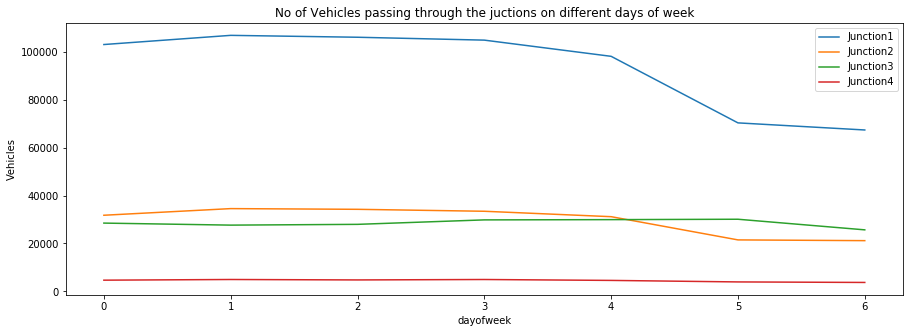

In [30]:
# No of vehicles based on day of week
fig = plt.figure(figsize=(15,5))
plt.title("No of Vehicles passing through the juctions on different days of week")
dow_1 = train[train.Junction ==1].groupby(['dayofweek'])['Vehicles'].sum()
dow_2 = train[train.Junction ==2].groupby(['dayofweek'])['Vehicles'].sum()
dow_3 = train[train.Junction ==3].groupby(['dayofweek'])['Vehicles'].sum()
dow_4 = train[train.Junction ==4].groupby(['dayofweek'])['Vehicles'].sum()
sns.lineplot(dow_1.index,dow_1,label='Junction1')
sns.lineplot(dow_2.index,dow_2,label='Junction2')
sns.lineplot(dow_3.index,dow_3,label='Junction3')
sns.lineplot(dow_4.index,dow_4,label='Junction4')

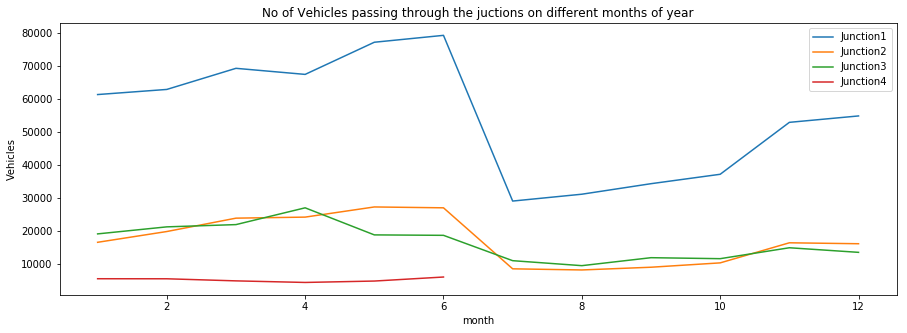

In [31]:
fig = plt.figure(figsize=(15,5))
plt.title("No of Vehicles passing through the juctions on different months of year")
moy_1 = train[train.Junction ==1].groupby(['month'])['Vehicles'].sum()
moy_2 = train[train.Junction ==2].groupby(['month'])['Vehicles'].sum()
moy_3 = train[train.Junction ==3].groupby(['month'])['Vehicles'].sum()
moy_4 = train[train.Junction ==4].groupby(['month'])['Vehicles'].sum()
sns.lineplot(moy_1.index,moy_1,label='Junction1')
sns.lineplot(moy_2.index,moy_2,label='Junction2')
sns.lineplot(moy_3.index,moy_3,label='Junction3')
sns.lineplot(moy_4.index,moy_4,label='Junction4')

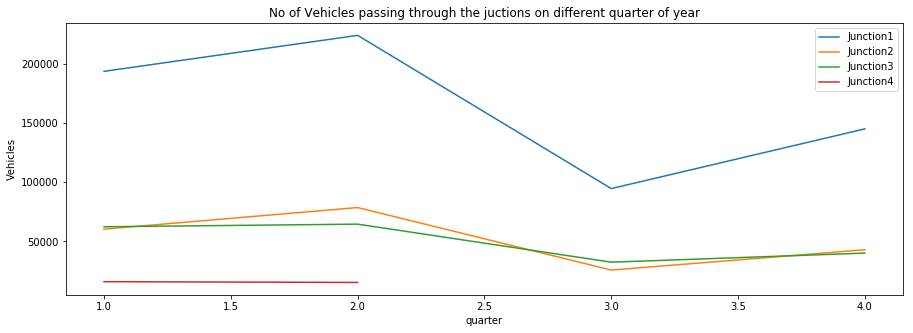

In [32]:
fig = plt.figure(figsize=(15,5))
plt.title("No of Vehicles passing through the juctions on different quarter of year")
qoy_1 = train[train.Junction ==1].groupby(['quarter'])['Vehicles'].sum()
qoy_2 = train[train.Junction ==2].groupby(['quarter'])['Vehicles'].sum()
qoy_3 = train[train.Junction ==3].groupby(['quarter'])['Vehicles'].sum()
qoy_4 = train[train.Junction ==4].groupby(['quarter'])['Vehicles'].sum()
sns.lineplot(qoy_1.index,qoy_1,label='Junction1')
sns.lineplot(qoy_2.index,qoy_2,label='Junction2')
sns.lineplot(qoy_3.index,qoy_3,label='Junction3')
sns.lineplot(qoy_4.index,qoy_4,label='Junction4')

In [13]:
test.shape

(11808, 3)

In [14]:
sub.shape

(11808, 2)

In [15]:
test.dtypes

DateTime    object
Junction     int64
ID           int64
dtype: object

In [16]:
test.isnull().sum()

DateTime    0
Junction    0
ID          0
dtype: int64

In [17]:
test['DateTime'] = pd.to_datetime(test['DateTime'])
test.DateTime.min(),test.DateTime.max()

(Timestamp('2017-07-01 00:00:00'), Timestamp('2017-10-31 23:00:00'))

In [18]:
createtimefeatures(test)
test.head()

,DateTime,Junction,ID,hour,dayofweek,quarter,month,year,dayofyear,dayofmonth,weekofyear
0,2017-07-01 00:00:00,1,20170701001,0,5,3,7,2017,182,1,26
1,2017-07-01 01:00:00,1,20170701011,1,5,3,7,2017,182,1,26
2,2017-07-01 02:00:00,1,20170701021,2,5,3,7,2017,182,1,26
3,2017-07-01 03:00:00,1,20170701031,3,5,3,7,2017,182,1,26
4,2017-07-01 04:00:00,1,20170701041,4,5,3,7,2017,182,1,26


In [39]:
total_daily = test.groupby(['year','dayofyear','Junction'])['Vehicles'].sum()
total_monthly = test.groupby(['month','dayofyear','Junction'])['Vehicles'].sum()
total_weekly = test.groupby(['weekofyear','dayofyear','Junction'])['Vehicles'].sum()

In [ ]:
import progressbar
from time import sleep
bar = progressbar.ProgressBar(maxval=train.shape[0], \
    widgets=[progressbar.Bar('=', '[', ']'), ' ', progressbar.Percentage()])
total_daily_count = []
total_monthly_count = []
total_weekly_count = []
k =0
bar.start()
for i in range(train.shape[0]) :
    total_daily_count.append(total_daily[test.iloc[i,8],test.iloc[i,9],test.iloc[i,1]])
    total_monthly_count.append(total_monthly[test.iloc[i,7],test.iloc[i,9],test.iloc[i,1]])
    total_weekly_count.append(total_weekly[test.iloc[i,11],test.iloc[i,9],test.iloc[i,1]])
    bar.update(i+1)
    k = k+1
bar.finish()
test['total_daily_count'] = total_daily_count
test['total_monthly_count'] = total_monthly_count
test['total_weekly_count'] = total_weekly_count

In [19]:
train.columns

Index(['DateTime', 'Junction', 'Vehicles', 'ID', 'hour', 'dayofweek',
       'quarter', 'month', 'year', 'dayofyear', 'dayofmonth', 'weekofyear'],
      dtype='object')

In [20]:
test.columns

Index(['DateTime', 'Junction', 'ID', 'hour', 'dayofweek', 'quarter', 'month',
       'year', 'dayofyear', 'dayofmonth', 'weekofyear'],
      dtype='object')

In [21]:
X = train[['Junction','ID','hour', 'dayofweek',
       'quarter', 'month', 'year', 'dayofyear', 'dayofmonth', 'weekofyear']]
y = train['Vehicles']

X,y  = np.array(X), np.array(y)

In [22]:
Xtst = test[['Junction', 'ID','hour', 'dayofweek', 'quarter', 'month',
       'year', 'dayofyear', 'dayofmonth', 'weekofyear']]
Xtst = np.array(Xtst)

In [23]:
X

array([[          1, 20151101001,           0, ...,         305,
                  1,          44],
       [          1, 20151101011,           1, ...,         305,
                  1,          44],
       [          1, 20151101021,           2, ...,         305,
                  1,          44],
       ...,
       [          4, 20170630214,          21, ...,         181,
                 30,          26],
       [          4, 20170630224,          22, ...,         181,
                 30,          26],
       [          4, 20170630234,          23, ...,         181,
                 30,          26]], dtype=int64)

In [24]:
Xtst

array([[          1, 20170701001,           0, ...,         182,
                  1,          26],
       [          1, 20170701011,           1, ...,         182,
                  1,          26],
       [          1, 20170701021,           2, ...,         182,
                  1,          26],
       ...,
       [          4, 20171031214,          21, ...,         304,
                 31,          44],
       [          4, 20171031224,          22, ...,         304,
                 31,          44],
       [          4, 20171031234,          23, ...,         304,
                 31,          44]], dtype=int64)

In [25]:
y

array([15, 13, 10, ..., 16, 22, 12], dtype=int64)

In [26]:
X_train,X_val,y_train,y_val = train_test_split(X,y,test_size =0.30,random_state=42)

In [27]:
X_train.shape,X_val.shape

((33684, 10), (14436, 10))

In [28]:
sc = StandardScaler()
X_train_scale = sc.fit_transform(X_train)
X_val_scale   = sc.transform(X_val)
Xtst_scale    = sc.transform(Xtst)
X_train_scale

array([[-0.19053524, -0.53843671, -1.66761405, ..., -1.41627805,
        -0.76367305, -1.45688542],
       [-0.19053524, -0.50474597, -0.36394502, ..., -0.86754836,
        -0.76367305, -0.88489277],
       [-1.22436078,  1.14907334,  0.65001978, ..., -1.21507716,
         1.74388566, -1.20266647],
       ...,
       [ 0.84329031, -0.37018998,  1.51913246, ...,  1.36395237,
        -0.87765299,  1.33952312],
       [-1.22436078, -2.03747161,  1.22942823, ...,  1.61088073,
        -1.10561288,  1.59374208],
       [-0.19053524, -2.0349744 , -1.23305771, ...,  1.74806316,
         0.60408624,  1.7844063 ]])

In [92]:
lin = LinearRegression() 
lin.fit(X_train_scale,y_train)
poly = PolynomialFeatures(degree = 2) 
X_poly = poly.fit_transform(X_train_scale)
Xtst_poly = poly.fit_transform(X_val_scale)
poly.fit(X_poly, y_train)
prp = poly.predict(X_val_scale)
math.sqrt(mse(y_val,svp))

AttributeError: 'PolynomialFeatures' object has no attribute 'predict'

In [166]:
clf = KNeighborsRegressor(n_neighbors=7)
clf.fit(X_train_scale,y_train)
knp = clf.predict(X_val_scale)
math.sqrt(mse(y_val,knp))

4.740004562250047

In [167]:
knp = clf.predict(Xtst_scale)
knp

array([50.71428571, 50.85714286, 44.28571429, ..., 14.71428571,
       13.57142857, 13.28571429])

In [168]:
clf = LinearSVC()
clf.fit(X_train_scale,y_train)
svp = clf.predict(X_val_scale)
math.sqrt(mse(y_val,svp))

19.545481272721887

In [169]:
svp = clf.predict(Xtst_scale)
svp

array([50, 20, 20, ..., 10, 10, 15], dtype=int64)

In [172]:
clf = DecisionTreeRegressor()
clf.fit(X_train_scale,y_train)
dtp = clf.predict(X_val_scale)
math.sqrt(mse(y_val,dtp))

4.598232038243438

In [173]:
dtp = clf.predict(Xtst_scale)
dtp

array([68., 55., 42., ..., 12., 12., 12.])

In [174]:
clf = RandomForestRegressor(n_estimators =900,max_depth=25,random_state=42)
clf.fit(X_train_scale,y_train)
rfp = clf.predict(X_val_scale)
math.sqrt(mse(y_val,rfp))

3.6215606425386806

[========================================================================] 100%


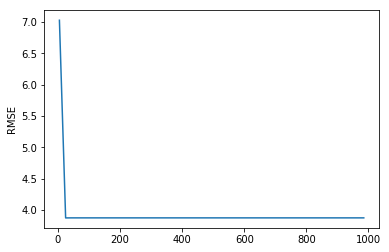

In [55]:
# Rndom Forest Hyperparameter tunning max_depth
val = {}
import progressbar
from time import sleep
bar = progressbar.ProgressBar(maxval=len(range(5,1000,20)), \
widgets=[progressbar.Bar('=', '[', ']'), ' ', progressbar.Percentage()])
k=0

bar.start()
for i in range(5,1000,20) :
    clf = RandomForestRegressor(max_depth=i,random_state=42)
    clf.fit(X_train,y_train)
    rfp = clf.predict(X_val)
    val[i] = math.sqrt(mse(y_val,rfp))
    bar.update(k+1)
    k = k+1
bar.finish()
valdf = pd.DataFrame.from_dict(val,orient='index')
valdf.columns = ['RMSE']
sns.lineplot(valdf.index,valdf.RMSE)

In [56]:
valdf

,RMSE
5,7.025706
25,3.872464
45,3.873269
65,3.873269
85,3.873269
105,3.873269
125,3.873269
145,3.873269
165,3.873269
185,3.873269


[========================================================================] 100%


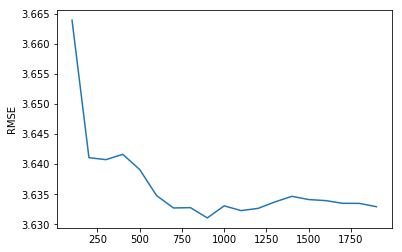

In [58]:
# Rndom Forest Hyperparameter tunning n_estimators for max_depth=25
val = {}
import progressbar
from time import sleep
bar = progressbar.ProgressBar(maxval=len(range(100,2000,100)), \
widgets=[progressbar.Bar('=', '[', ']'), ' ', progressbar.Percentage()])
k=0

bar.start()
for i in range(100,2000,100) :
    clf = RandomForestRegressor(n_estimators=i,max_depth=25,random_state=42)
    clf.fit(X_train,y_train)
    rfp = clf.predict(X_val)
    val[i] = math.sqrt(mse(y_val,rfp))
    bar.update(k+1)
    k = k+1
bar.finish()
valdf = pd.DataFrame.from_dict(val,orient='index')
valdf.columns = ['RMSE']
sns.lineplot(valdf.index,valdf.RMSE)

In [59]:
valdf

,RMSE
100,3.663928
200,3.641077
300,3.640745
400,3.641635
500,3.639104
600,3.634769
700,3.632713
800,3.632768
900,3.631059
1000,3.633066


In [61]:
rfp = clf.predict(Xtst)
rfp

array([71.04111111, 56.69666667, 43.89777778, ..., 15.27444444,
       18.00111111, 14.37111111])

In [175]:
rfp = clf.predict(Xtst_scale)
rfp

array([70.74666667, 56.67444444, 43.87222222, ..., 15.36555556,
       15.93777778, 14.03666667])

In [129]:
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score,cross_val_predict
from sklearn.metrics import mean_squared_error as mse

In [43]:
crossval_scores = cross_val_score(RandomForestRegressor(), X, y,cv=25)
cv_predict_val = cross_val_predict(RandomForestRegressor(),X,y,cv =25)
rfc = RandomForestRegressor().fit(X,y)
rfp = rfc.predict(Xtst)
crossval_scores

array([-1.28417197e+01,  7.61983793e-01,  7.88016338e-01,  6.53564714e-01,
        7.94948953e-01,  7.44028641e-01,  6.77267193e-01,  9.55116196e-01,
        2.00902376e-01,  4.85357504e-01,  6.54515372e-01,  5.94271319e-01,
       -3.56301948e-01,  5.10866438e-01,  1.84621862e-01, -7.00278817e-02,
       -4.25447595e-02, -2.64826411e-02,  1.42379815e-01,  1.79030592e-01,
        2.71120229e-01,  2.14799215e-03, -5.44958563e-01,  2.45198223e-01,
        8.01503081e-02])

In [44]:
rfp

array([70. , 55.4, 48.9, ..., 16.4, 18.2, 12.8])

In [35]:
rfp = clf.predict(Xtst)
rfp

array([21., 17., 18., ...,  6.,  6.,  6.])

In [130]:
crossval_scores = cross_val_score(XGBRegressor(n_estimators = 300,max_depth =10,
                            objective = 'reg:squarederror',njobs=-1), X, y,cv=5)
cv_predict_val = cross_val_predict(RandomForestRegressor(),X,y,cv =5)
xgc = XGBRegressor(n_estimators = 300,max_depth =10,
                   objective = 'reg:squarederror',njobs=-1).fit(X,y)
xgp = xgc.predict(Xtst)
crossval_scores

array([-1.22500499,  0.75254439, -0.08017302,  0.06779643, -0.98036299])

In [131]:
xgp

array([71.936356, 58.201763, 47.493923, ..., 13.954833, 14.56861 ,
       13.444924], dtype=float32)

In [150]:
clf = XGBRegressor(n_estimators = 1000,max_depth =10,objective = 'reg:squarederror',
                   njobs=-1)
#clf = XGBRegressor(eval_metrics =mse,njobs=-1)
clf.fit(X_train,y_train)
xgp = clf.predict(X_val)
math.sqrt(mse(y_val,xgp))

3.5544238270656985

In [151]:
xgp = clf.predict(Xtst)
xgp

array([70.876396, 58.843487, 48.066753, ..., 19.192099, 20.885708,
       18.007051], dtype=float32)

In [148]:
clf = ltb.LGBMRegressor(njob=-1)
clf.fit(X_train,y_train)
lgp = clf.predict(X_val)
math.sqrt(mse(y_val,lgp))

4.524358699357012

In [149]:
lgp = clf.predict(Xtst)
lgp

array([66.5395332 , 57.36012014, 47.50832683, ...,  9.91333807,
        9.37819231,  7.76303341])

In [54]:
# ensemble models -- simple mean
emp = (rfp+xgp+lgp) /3
emp

array([70.89769508, 57.19745426, 45.81136533, ...,  9.1213052 ,
       11.8498273 ,  9.05173622])

In [124]:
# use stacking to ensemble multiple models to improve the score
ridge = RidgeCV()
#ds    = DecisionTreeRegressor(max_depth=25)
rf    = RandomForestRegressor(n_estimators =900,max_depth=25,random_state=42)
xgb   = XGBRegressor(n_estimators = 1000,max_depth =10,eval_metrics = mse,njobs=-1)
stkreg = StackingRegressor(regressors=[xgb, ridge],meta_regressor=xgb)
stkreg.fit(X_train,y_train)
stenp = stkreg.predict(X_val)
math.sqrt(mse(y_val,stenp))

[22:17:38] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[22:19:09] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


3.6696469600270705

In [125]:
stenp = stkreg.predict(Xtst)
stenp

array([68.87265 , 58.021633, 47.66754 , ..., 19.113052, 21.680197,
       18.14938 ], dtype=float32)

In [86]:
sub.head()

,ID,Vehicles
0,20170701001,50
1,20170701011,50
2,20170701021,50
3,20170701031,50
4,20170701041,50


In [37]:
knpdf = pd.DataFrame(knp)
sub_df = sub['ID']
sub_df = pd.concat([sub_df,knpdf],axis =1)
sub_df.columns = ['ID','Vehicles']

In [ ]:
svpdf = pd.DataFrame(svp)
sub_df = sub['ID']
sub_df = pd.concat([sub_df,svpdf],axis =1)
sub_df.columns = ['ID','Vehicles']

In [ ]:
dtpdf = pd.DataFrame(dtp)
sub_df = sub['ID']
sub_df = pd.concat([sub_df,dtpdf],axis =1)
sub_df.columns = ['ID','Vehicles']

In [43]:
rfpdf = pd.DataFrame(rfp)
sub_df = sub['ID']
sub_df = pd.concat([sub_df,rfpdf],axis =1)
sub_df.columns = ['ID','Vehicles']

In [97]:
xgpdf = pd.DataFrame(xgp)
sub_df = sub['ID']
sub_df = pd.concat([sub_df,xgpdf],axis =1)
sub_df.columns = ['ID','Vehicles']

In [41]:
lgpdf = pd.DataFrame(lgp)
sub_df = sub['ID']
sub_df = pd.concat([sub_df,lgpdf],axis =1)
sub_df.columns = ['ID','Vehicles']

In [56]:
empdf = pd.DataFrame(emp)
sub_df = sub['ID']
sub_df = pd.concat([sub_df,empdf],axis =1)
sub_df.columns = ['ID','Vehicles']

In [126]:
stenpdf = pd.DataFrame(stenp)
sub_df = sub['ID']
sub_df = pd.concat([sub_df,stenpdf],axis =1)
sub_df.columns = ['ID','Vehicles']

In [ ]:
sub_df.to_csv(r'E:\Pattabhiraman\Personal\JHack-ioT\sv01.csv', index=False)

In [ ]:
sub_df.to_csv(r'E:\Pattabhiraman\Personal\JHack-ioT\dt01.csv', index=False)

In [44]:
sub_df.to_csv(r'E:\Pattabhiraman\Personal\JHack-ioT\rf08.csv', index=False)

In [98]:
sub_df.to_csv(r'E:\Pattabhiraman\Personal\JHack-ioT\xg04.csv', index=False)

In [42]:
sub_df.to_csv(r'E:\Pattabhiraman\Personal\JHack-ioT\lg03.csv', index=False)

In [57]:
sub_df.to_csv(r'E:\Pattabhiraman\Personal\JHack-ioT\em01.csv', index=False)

In [38]:
sub_df.to_csv(r'E:\Pattabhiraman\Personal\JHack-ioT\knn01.csv', index=False)

In [127]:
sub_df.to_csv(r'E:\Pattabhiraman\Personal\JHack-ioT\stenp03.csv', index=False)